# Deep Generative Models with Autoregressive models

### Problem 1: Sampling from KDE

In our course we will discuss mostly parametric generative models. It means that our model $p(\mathbf{x} | \boldsymbol{\theta})$ defined by the parameters $\boldsymbol{\theta}$.

But there are also the set of non-parametric models. One of the examples of such models is **kernel density models**. 

Let define Kernel Density Estimator for the density $\pi(\mathbf{x})$ in the following form:
$$
    \hat{p}_h(x) = \frac{1}{n h^d} \sum\limits_{i = 1}^{n} K\left(\frac{\mathbf{x} - \mathbf{x}_i}{h}\right),
$$
where $\mathbf{x}_1, \dots, \mathbf{x}_n \sim \pi(\mathbf{x})$, $\mathbf{x}_i \in \mathbb{R}^m$.
Here function $K(\mathbf{x}): \mathbb{R}^m \rightarrow \mathbb{R}$ is function that satisfies the following properties:
1) it is non-negative, $K(\mathbf{x}) \geq 0$;
2) it is symmetric, $K(\mathbf{x}) = K(-\mathbf{x})$;
3) it is normalized, $ \int K(\mathbf{x}) d \mathbf{x} = 1$.

Consider the following sampling scheme:
>
>1. Choose random number $k$ uniformly from the collection of numbers $\{1, 2, \dots, n\}$.
>
>2. Sample the random variable $\tilde{\mathbf{x}}$ from the kernel $\frac{1}{h^d} K\left(\frac{\mathbf{x} - \mathbf{x}_k}{h}\right)$.
>

Discuss that if $\tilde{X}$ is distributed according to $\hat{p}_h(\mathbf{x})$, i.e. the scheme above is the correct sampling scheme for $\hat{p}_h(\mathbf{x})$.

### Problem 2 (bonus!): Curse of dimensionality

The main problem of generative modelling is the curse of dimensionality. Let try to get some intuition about it.

Let consider a sphere of radius $r = 1$ in $\mathbb{R}^m$. Let say that if has the volume $V_m(r)$. Our goal is to find the fraction of the volume of the sphere that lies between radius $r = 1 - \epsilon$ and $r = 1$. Our geometric intuition is that this fraction is small. But the magic happens with $m$ goes to infinity.

1. Find the expression of the volume of a shpere of radius $r$ in $m$ dimensions.

2. Find the required fraction $\Delta = \frac{V_m(1) - V_m(1 - \epsilon)}{V_m(1)}$.

3. Prove that, for large $m$, the fraction tends to 1 even for small values of $\epsilon$.

## Task 2: PixelCNN receptive field

[PixelCNN](https://arxiv.org/abs/1601.06759) model uses masked causal convoultions on images, we have discussed this model on the lecture.

The PixelCNN model is a powerful model. But the model has drawbacks.

1. The model is sequential and sampling is really slow (it is a drawback of all AR models).

2. The receptive field of the model is not so large. Even if the model is well-trained, the samples do not have long-range history.

We will analyze these drawbacks.

But first of all we need to train this model.

### Step 0: Some imports and useful functions

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from typing import Dict, List, Optional, Tuple
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
from torchvision.utils import make_grid


TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

USE_CUDA = torch.cuda.is_available()

# Set a seed for reproducibility
seed = 42
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
def load_MNIST(with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data.numpy(), test_dataset.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, test_data, train_labels, test_labels

    return train_data, test_data


def load_CIFAR10(with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    train_dataset = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data, test_dataset.data

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, test_data, train_labels, test_labels

    return train_data, test_data


def _load_dataset(name: str, with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST(with_targets=with_targets)
    elif name == "cifar10":
        return load_CIFAR10(with_targets=with_targets)
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = True, with_targets: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    dataset = _load_dataset(name, with_targets=with_targets)

    train_data = dataset[0]
    test_data = dataset[1]

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    if with_targets:
        train_labels = dataset[2]
        test_labels = dataset[3]
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data


def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def plot_training_curves(
    train_losses: Dict[str, np.ndarray],
    test_losses: Dict[str, np.ndarray],
    logscale_y: bool = False,
    logscale_x: bool = False,
) -> None:
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + "_train")

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + "_test")

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Loss", fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()


def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)


def visualize_2d_data(
    train_data: np.ndarray,
    test_data: np.ndarray,
    train_labels: Optional[str] = None,
    test_labels: Optional[str] = None,
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("train", fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title("test", fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_samples(
    data: np.ndarray,
    title: str,
    labels: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=1, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_densities(
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    densities: np.ndarray,
    title: str,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()

### Step 1: Let's be one with the model and the data

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 6808313.95it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 269397.57it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2662103.27it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3404311.79it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



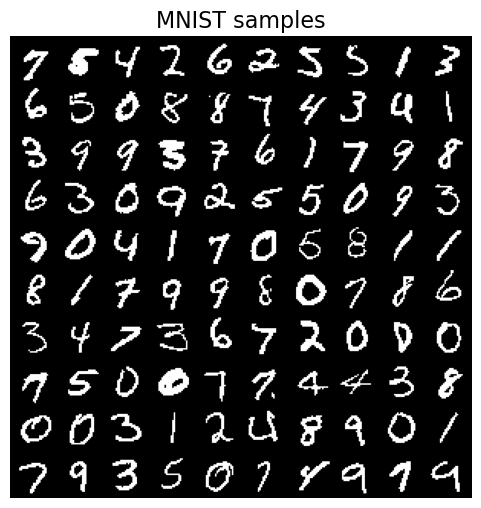

In [4]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

Masked Convolution Layer is the basic building block of PixelCNN model. Look carefully at this code.

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)

    def create_mask(self, mask_type: str) -> None:
        # try to understand the logic about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process, as we discussed at Transformer lecture

In [6]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Now we are ready to define the main PixelCNN model.

In [7]:
class PixelCNN(nn.Module):
    def __init__(
        self,
        input_shape: tuple[int],
        n_filters: int = 64,
        kernel_size: int = 7,
        n_layers: int = 5,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape

        # we apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        model = [MaskedConv2d("A", 1, n_filters, kernel_size=kernel_size)]

        for _ in range(n_layers):
            if use_layer_norm:
                model.append(LayerNorm(n_filters))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", n_filters, n_filters, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=n_filters, out_channels=2, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x: torch.Tensor) -> dict:
        # our loss is just cross entropy
        total_loss = F.cross_entropy(self(x), x.long())
        return {"total_loss": total_loss}

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(
                    -1
                )
        return samples.cpu().numpy()

### Step 2: Train the model with proper parameters based on your understanding of the model

In [ ]:
# ====
# your code
# choose these parameters
EPOCHS = 
BATCH_SIZE = 
LR = 
N_LAYERS = 
N_FILTERS = 
USE_LAYER_NORM = 
# ====

model = PixelCNN(
    input_shape=(28, 28),
    n_filters=N_FILTERS,
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

loss = model.loss(torch.zeros(1, 1, 28, 28))
assert isinstance(loss, dict)
assert "total_loss" in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

test_loss = test_losses["total_loss"][-1]
print(
    f"Test loss: {test_loss:.2f}",
)
assert test_loss < 0.10

Even if the test loss is bigger than the value in assert, try to visualize train/test curves, it could find you to find the bug.

In [ ]:
plot_training_curves(train_losses, test_losses)

Now we sample the new images from the model. Notice that the sampling from the autoregressive model is slow, because it is a sequential process.

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)

### Step 3: Receptive field

Let try to visualize the receptive field of the model, the receptive field is the area of the input image that contributes to the computation of a particular output pixel. A larger receptive field enables the model to capture long-range dependencies and more complex patterns in the image, which is crucial for tasks like image generation where the relationship between distant pixels matters.

We should see that the receptive field grows with increasing number of convolutional layers.

The receptive field can be empirically measured by backpropagating an arbitrary loss for the output features of a specific pixel with respect to the input. We implement this idea below, and visualize the receptive field below.

In [ ]:
def plot_receptive_field(model: object, model_name: str) -> None:
    # ====
    # your code
    # 1) create tensor with zeros and set required_grad to True.
    # 2) apply model to the tensor
    # 3) apply backward() to the center pixel of model output
    # 4) take the gradient with respect to input
    # 5) binary receptive field is an indicator map in which we stay 1's if gradient more than 1e-8
    # 6) weighted receptive field is the normalized gradient (values lies in [0, 1])

    # ====

    # we stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

In [ ]:
for n_layers in [1, 3, 5, 6]:
    model = PixelCNN(
        input_shape=(28, 28),
        n_filters=32,
        kernel_size=5,
        n_layers=n_layers,
        use_layer_norm=True,
    )
    if USE_CUDA:
        model = model.cuda()
    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")

You have to see that PixelCNN has strange blind spot in binary receptive field plot on the right side. This is a known issue of PixelCNN model. Please, try to understand why it happens.

One way to solve this problem is a [GatedPixelCNN](https://arxiv.org/pdf/1606.05328.pdf) model (see paper, if you are interested in).

### Step 4: Image autocompletion (bonus!)

One more feature of autoregressive model that we try is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first pixels to predefined values and check how the model completes the image.

For implementing this, we just need to skip the iterations in the sampling loop that already have a value unequals to -1.
We redefine the sample method in our PixelCNN class to allow it to take the init of the sample.

In [ ]:
class PixelCNNAutoComplete(PixelCNN):
    @torch.no_grad()
    def sample(self, n: int, init: Optional[torch.Tensor] = None) -> np.ndarray:
        # ====
        # your code
        # this method almost the same as the method of the base PixelCNN model
        # but now if init is given, this tensor will be used as a starting image.
        # The pixels to fill should be -1 in the input tensor.
        
        # ====

You have to repeat the model training.

In [ ]:
model = PixelCNNAutoComplete(
    input_shape=(28, 28),
    n_filters=N_FILTERS,
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

assert test_losses["total_loss"][-1] < 0.10

We randomly take images from the training set, mask the lower half of the image (set -1's), and let the model autocomplete it. We do this several times for each image to see the diversity of samples.

In [ ]:
def autocomplete_image(image: np.ndarray, model: object, n_samples: int) -> None:
    # Remove lower half of the image
    image_init = image.copy()
    image_init[:, image.shape[1] // 2 :, :] = -1
    samples = np.stack([image, np.maximum(image_init, 0)])
    show_samples(samples, title="Original image and input image to sampling", nrow=2)
    # Generate completions
    image_init = torch.tensor(image_init)
    image_init = (
        image_init.unsqueeze(dim=0).expand(n_samples, -1, -1, -1).to(model.device)
    )
    img_generated = model.sample(n_samples, image_init)
    show_samples(img_generated, title="n_samples", nrow=4)


for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)

## Task 3: ImageGPT on MNIST

In this task you will try to implement the Image Transformer net for an autoregressive generation MNIST images. See the [blog](https://openai.com/blog/image-gpt/) and [paper](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) for details.

### Architecture

Let's describe the model architecture.

Image Transformer consists of $L$ identical blocks similar to Transformer decoder blocks we have seen in the lecture. These blocks are applied sequentially. The $l$th block receives a tensor $\mathbf{h}^l$ with shape (batch_size, pixel_num, emb_dim) where pixel_num is a total number of pixels $(28*28)$ and emb_dim is a hyperparameter for the size of the embeddings.

The tensor is transformed as follows:
\begin{align}
    \mathbf{n}^l &= \text{layer\_norm}(\mathbf{h}^l), \\
    \mathbf{a}^l &= \mathbf{h}^l + \text{multihead\_attention}(\mathbf{n}^l), \\
    \mathbf{h}^{l+1} &= \mathbf{a}^l + \text{MLP}(\text{layer\_norm}(a^l)). \\
\end{align}

As we have discussed several times, each head of the multihead attention computes an embedding
$$
    \text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}) \mathbf{V},
$$
where $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ - query/key/value matrices obtained using Linear projection of $\mathbf{h}^l$.
Then embeddings across all heads are stacked and followed by a linear layer.

We will use just 2 Linear layers with ReLU activation for MLP.

Embedding $h^1$ (our first embedding) is a sum of a token embedding of the input batch and learned positional embedding.

After the last block we will apply a LayerNorm and a Linear layer to obtain logits of size (batch_size, pixel_num, 2)
$$
\begin{align*}
  n^L &= \text{layer\_norm}(h^L) \\
  \text{logits} &= \text{linear}(n^L)
\end{align*}
$$

### Autoregressive property
Just like the the Homework on Transformers, to make the model autoregressive we will introduce the following changes:

1. We will apply the upper triangular mask to the matrix of attention logits ($\mathbf{Q}\mathbf{K}^T$). Masked values are made close to minus infinity so they will turn zero after softmax.
2. During training we will add "start of sequence" token to the input tensor and pop the last pixel.

Note: we will use raster order to identify which pixels come first (as we have done in PixelCNN). For each pixel the predicted probabality is conditioned on all the previous pixels.

### Step 1: Let start with the multihead attention block.

In [ ]:
class MultiheadAttention(nn.MultiheadAttention):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        super().__init__(embed_dim, num_heads)

    def get_attention_mask(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # define attention mask, it should contain
        # - zeros under and on the main diagonal
        # - minus Inf above the main diagonal
        
        # ====
        return attention_mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_mask = self.get_attention_mask(x)
        return super().forward(x, x, x, attn_mask=attn_mask, need_weights=False)[0]


def test_attention_mask() -> None:
    x = torch.zeros(2, 4, 16)  # (pixel_num, batch_size, emb_dim)
    mask = np.array([[0.0, -np.inf], [0.0, 0.0]])
    layer = MultiheadAttention(16, 8)
    attention_mask = layer.get_attention_mask(x)
    assert attention_mask.size() == (x.size(0), x.size(0))
    assert np.allclose(attention_mask.numpy(), mask)
    out = layer(x)
    assert x.size() == out.size()


test_attention_mask()

### Step 2: Now we will define the base decoder block.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        """
        :param embed_dim: dimension of embedding space
        :param num_heads: number of attention heads
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        # ====
        # your code
        # define multihead attention (https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        # define LayerNorm
        # (here we do not use previous class for LayerNorm because we do not need to change order of tensor dimensions)
        # define MLP - 2 linear layers with ReLU
        # (You could choose the latent dimensionality of MLP as you like. For example, double the embed_dim)

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # here you have to implement formulas that described above.

        # ====
        return x


def test_decoder_block() -> None:
    block = DecoderBlock(embed_dim=12, num_heads=4)
    x = torch.zeros(4, 28, 12)
    assert x.shape == block(x).shape


test_decoder_block()

In [ ]:
class ImageGPT(nn.Module):
    def __init__(
        self, input_shape: tuple[int], embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        super().__init__()

        self.embed_dim = embed_dim
        self.input_shape = input_shape
        self.criterion = nn.BCEWithLogitsLoss()

        # "start of sequence" token (we initialize it from Normal distribution)
        self.sos = torch.nn.Parameter(torch.zeros(embed_dim))
        nn.init.normal_(self.sos)

        # ====
        # your code
        # 1) define token_embeddings
        #    (we will have 2 embeddings in total, because our images are binary)
        # 2) define position_embeddings (they will be learnable)
        
        # ====

        self.layers = nn.ModuleList()
        # ====
        # your code
        # 1) add decoder blocks to self.layers list
        # 2) define last LayerNorm
        # 3) define final Linear layer (without bias)
        
        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def add_sos_token(self, embeddings: torch.Tensor) -> torch.Tensor:
        batch_size = embeddings.size(1)
        # ====
        # your code
        # prepend sos (start of sequence) token
        # 1) repeat sos token batch_size times (make it of size (1, batch_size, emd_size))
        # 2) drop last embedding from embeddings
        # 3) concat repeated sos token to embeddings (after dropping)
        
        # ====
        return embeddings

    def add_pos_embeddings(self, embeddings: torch.Tensor) -> torch.Tensor:
        length = embeddings.size(0)
        # ====
        # your code
        # add positional embeddings
        # 1) define tensor with positions (just torch.arange) of size (length, 1)
        # 2) add position embeddings to initial embeddings
        
        # ====
        return embeddings

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.long()
        x = x.reshape(x.size(0), -1)  # (batch_size, length)
        x = x.permute(1, 0)

        embeddings = self.token_embeddings(x)  # (length, batch_size, emb_size)
        embeddings = self.add_sos_token(embeddings)
        embeddings = self.add_pos_embeddings(embeddings)

        # ====
        # your code
        # 1) apply all decoder layers
        # 2) apply final LayerNorm and Linear layer
        
        # ====

        return logits.permute(
            1, 0, 2
        )  # (length, batch_size, emb_size) -> (batch_size, length, emb_size)

    def loss(self, x: torch.Tensor) -> dict:
        logits = self(x)
        loss = self.criterion(logits.reshape(-1), x.reshape(-1).float())
        return {"total_loss": loss}

    @torch.no_grad()
    def sample(self, n_samples: int) -> np.ndarray:
        # read sampling carefully
        seq_len = self.input_shape[0] * self.input_shape[1]
        samples = torch.zeros(n_samples, seq_len).long().to(self.device)
        for i in range(seq_len):
            logits = self(samples)
            dist = torch.distributions.Bernoulli(logits=logits[:, i, 0])
            samples[:, i] = dist.sample()
        samples = samples.reshape(n_samples, 1, *self.input_shape)
        return samples.cpu().numpy()


def test_image_gpt() -> None:
    image_gpt = ImageGPT(input_shape=(2, 2), embed_dim=12, num_heads=4, num_layers=2)
    x = torch.LongTensor([[0, 1, 0, 0], [0, 1, 1, 1]])
    assert image_gpt(x).shape == torch.Size([2, 4, 1])
    assert image_gpt.loss(x)["total_loss"].requires_grad == True
    assert image_gpt.sample(1).shape == torch.Size([1, 1, 2, 2])
    img = torch.randint(2, size=(1, 1, 2, 2))


test_image_gpt()

### Step 3: Model training

Now we are ready to train our model.

In [ ]:
# ====
# your code
# choose these parameters
EPOCHS = 
BATCH_SIZE = 
LR = 

EMB_DIM = 
NUM_HEADS = 
NUM_LAYERS = 
# ====

model = ImageGPT((28, 28), EMB_DIM, NUM_HEADS, NUM_LAYERS)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

In [ ]:
plot_training_curves(train_losses, test_losses)

Let sample from our model. You probably get better samples than PixelCNN samples.

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)